# Natural Gas Predictor
## This notebook is designed to give some more insight to given data and try to train neural network with chosen attributes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from math import ceil, floor
import numpy as np
from sklearn.model_selection import train_test_split

FILE_URL = 'https://www.eia.gov/opendata/bulk/NG.zip'
SPOT_PRICE_DAILY_ID = 'NG.RNGWHHD.D'
MAIN_STORAGE_ID = 'NG.NW2_EPG0_SWO_R48_BCF.W'
# NG.N5020US2.M - Total U.S. Natural Gas Storage Monthly. Can be incorporated later to enhance the model.
ALL_IDS = [SPOT_PRICE_DAILY_ID,
           'NG.NW2_EPG0_SWO_R48_BCF.W', 'NG.N9070US2.M', 'NG.N9140US1.M', 'NG.N9130US2.M']

## Download latest version of natural gas info file and unzip it

In [2]:
# import urllib.request

# _ = urllib.request.urlretrieve(FILE_URL, "NG.zip")

In [3]:
# from zipfile import ZipFile
  
# with ZipFile("NG.zip", 'r') as nat_gas_zipped:
#     nat_gas_zipped.extractall()

## Open the file and drop rows without data


In [4]:
with open("NG.txt", "r") as f:
    df = pd.read_json(f, lines=True)

In [5]:
df = df[df['data'].notna()]

In [6]:
df.columns

Index(['series_id', 'name', 'units', 'f', 'unitsshort', 'description',
       'copyright', 'source', 'start', 'end', 'last_updated', 'data',
       'iso3166', 'geography', 'geography2', 'category_id',
       'parent_category_id', 'notes', 'childseries'],
      dtype='object')

### Load Futures Prices

In [7]:
def parse_km(x):
    if isinstance(x, str):
        x = x.strip()
        if x.endswith("K"):
            return float(x[:-1]) * 1_000
        if x.endswith("M"):
            return float(x[:-1]) * 1_000_000
    return float(x)

def read_csv_autoencoding(path):
    for enc in ['utf-8', 'utf-8-sig', 'latin1', 'cp1250']:
        try:
            df = pd.read_csv(path, encoding=enc)
            print(f"✅ Loaded {path} using {enc}")
            return df
        except Exception as e:
            continue
    raise ValueError(f"❌ Could not read {path} with common encodings")

# --- Wczytanie trzech plików ---
futures = read_csv_autoencoding("NewData/Natural Gas Futures Historical Data.csv")

# --- Normalizacja nazw kolumn ---
futures.rename(columns={c: f"Futures {c}" for c in futures.columns if c != "Date"}, inplace=True)
futures.rename(columns={"Date": "date"}, inplace=True)
futures['Futures Vol.'] = futures['Futures Vol.'].apply(parse_km)

# --- Konwersja dat ---
futures["date"] = pd.to_datetime(futures["date"], errors="coerce")

futures.drop(columns=["Futures Change %"], inplace=True)

✅ Loaded NewData/Natural Gas Futures Historical Data.csv using utf-8


In [8]:
def read_row_of_data(row_name=None, row_id=None, series_name=None):
    if row_name:
        row_filter = df['name'] == row_name
    elif row_id:
        row_filter = df['series_id'] == row_id
        row_name = df[row_filter]['name'].to_list()[0]
    data = df[row_filter]['data'].to_list()
    try:
        observation_dates = [datetime.datetime.strptime(
            el[0], '%Y%m%d').date() for el in data[0]]
    except ValueError as e:
        try:
            observation_dates = [datetime.datetime.strptime(
                el[0], '%Y%m').date() for el in data[0]]
        except ValueError as e:
            observation_dates = [datetime.datetime.strptime(
                el[0], '%Y').date() for el in data[0]]
    return pd.Series(
        data=[el[1] for el in data[0]], index=pd.DatetimeIndex(observation_dates), name=row_name)

## Creating dataframe with chosen series ready for learning NN

In [9]:
chosen_data_list = []
for series_id in ALL_IDS:
    chosen_data_list.append(read_row_of_data(row_id=series_id))
chosen_data_df = pd.concat([*chosen_data_list, futures.set_index('date')], axis=1, join='outer')

In [10]:
chosen_data_df.tail()

,"Henry Hub Natural Gas Spot Price, Daily","Weekly Lower 48 States Natural Gas Working Underground Storage, Weekly","U.S. Dry Natural Gas Production, Monthly","U.S. Natural Gas Total Consumption, Monthly","U.S. Natural Gas Exports, Monthly",Futures Price,Futures Open,Futures High,Futures Low,Futures Vol.
2025-11-10,3.8,NaN,NaN,NaN,NaN,4.338,4.480,4.509,4.262,189080.0
2025-11-11,NaN,NaN,NaN,NaN,NaN,4.565,4.375,4.581,4.276,243690.0
2025-11-12,3.6,NaN,NaN,NaN,NaN,4.533,4.526,4.582,4.461,170350.0
2025-11-13,NaN,NaN,NaN,NaN,NaN,4.646,4.535,4.688,4.454,630.0
2025-11-14,NaN,NaN,NaN,NaN,NaN,4.520,4.601,4.635,4.478,35110.0


In [11]:
chosen_data_df = chosen_data_df.sort_index()
columns_for_filling = ['Weekly Lower 48 States Natural Gas Working Underground Storage, Weekly', 'U.S. Dry Natural Gas Production, Monthly', 'U.S. Natural Gas Total Consumption, Monthly',	'U.S. Natural Gas Exports, Monthly', 'Henry Hub Natural Gas Spot Price, Daily']
chosen_data_df[columns_for_filling] = chosen_data_df[columns_for_filling].fillna(method='ffill')
# chosen_data_df = chosen_data_df.loc[:, ~
#                                      chosen_data_df.columns.duplicated()].copy()
chosen_data_df = chosen_data_df[~chosen_data_df[['Henry Hub Natural Gas Spot Price, Daily', 'Futures Price', 'Weekly Lower 48 States Natural Gas Working Underground Storage, Weekly']].isna().any(axis=1)]

In [12]:
# Adding properties of date as input data
chosen_data_df['Day of the week'] = chosen_data_df.index.dayofweek
chosen_data_df['Day'] = chosen_data_df.index.day
chosen_data_df['Month'] = chosen_data_df.index.month
chosen_data_df['Year'] = chosen_data_df.index.year

In [13]:
chosen_data_df.head()

,"Henry Hub Natural Gas Spot Price, Daily","Weekly Lower 48 States Natural Gas Working Underground Storage, Weekly","U.S. Dry Natural Gas Production, Monthly","U.S. Natural Gas Total Consumption, Monthly","U.S. Natural Gas Exports, Monthly",Futures Price,Futures Open,Futures High,Futures Low,Futures Vol.,Day of the week,Day,Month,Year
2010-01-04,6.09,3117.0,1737233.0,2810.0,93570.0,5.884,5.705,5.894,5.705,78860.0,0,4,1,2010
2010-01-05,6.19,3117.0,1737233.0,2810.0,93570.0,5.637,5.837,5.858,5.615,99490.0,1,5,1,2010
2010-01-06,6.47,3117.0,1737233.0,2810.0,93570.0,6.009,5.690,6.075,5.650,140610.0,2,6,1,2010
2010-01-07,7.51,3117.0,1737233.0,2810.0,93570.0,5.806,6.033,6.108,5.763,135110.0,3,7,1,2010
2010-01-08,6.56,2850.0,1737233.0,2810.0,93570.0,5.749,5.827,5.853,5.621,101150.0,4,8,1,2010


In [14]:
# Adding properties for storage changes
chosen_data_df['Storage change 1w'] = chosen_data_df['Weekly Lower 48 States Natural Gas Working Underground Storage, Weekly'] - chosen_data_df['Weekly Lower 48 States Natural Gas Working Underground Storage, Weekly'].shift(freq='7D')

In [15]:
def get_shifted_column(df, column_name, offset):
    df_shifted = df[column_name].copy()
    df_shifted.index = df_shifted.index + offset
    df_shifted = df_shifted[~df_shifted.index.duplicated(keep='first')]
    return df_shifted

In [16]:
chosen_data_df['Storage change 1y'] = chosen_data_df['Weekly Lower 48 States Natural Gas Working Underground Storage, Weekly'] - get_shifted_column(chosen_data_df, 'Weekly Lower 48 States Natural Gas Working Underground Storage, Weekly', pd.DateOffset(years=1))
chosen_data_df['Delta change 1w vs last_year'] = chosen_data_df['Storage change 1w'] - get_shifted_column(chosen_data_df, 'Storage change 1w', pd.DateOffset(years=1))

Overview of chosen data

In [17]:
chosen_data_df.columns

Index(['Henry Hub Natural Gas Spot Price, Daily',
       'Weekly Lower 48 States Natural Gas Working Underground Storage, Weekly',
       'U.S. Dry Natural Gas Production, Monthly',
       'U.S. Natural Gas Total Consumption, Monthly',
       'U.S. Natural Gas Exports, Monthly', 'Futures Price', 'Futures Open',
       'Futures High', 'Futures Low', 'Futures Vol.', 'Day of the week', 'Day',
       'Month', 'Year', 'Storage change 1w', 'Storage change 1y',
       'Delta change 1w vs last_year'],
      dtype='object')

In [18]:
# Filtering out data before 2001 because they lack most of the informations
chosen_data_df = chosen_data_df[chosen_data_df.index >= datetime.datetime(2001, 1, 1)]

Plotting histograms and boxplots for chosen series

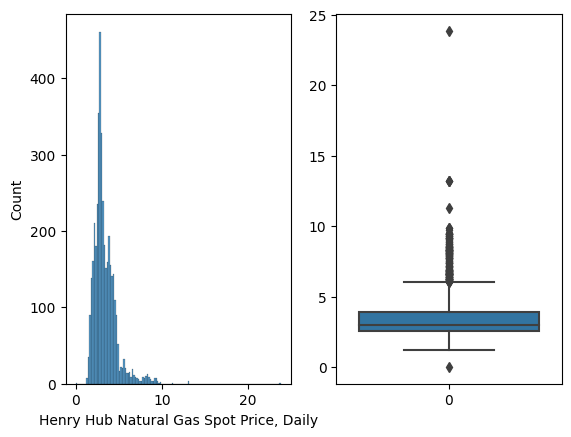

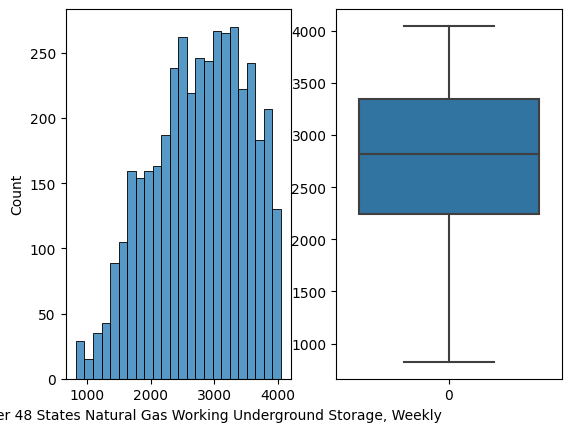

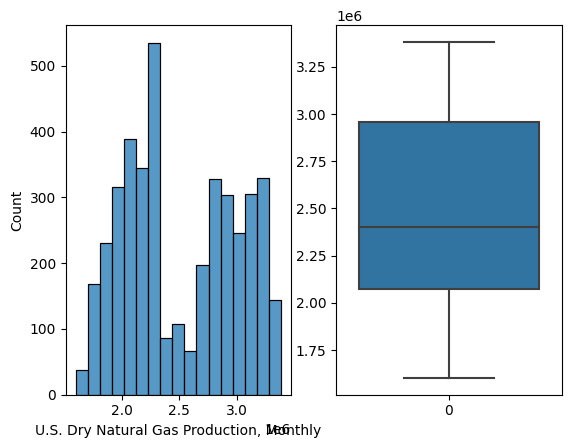

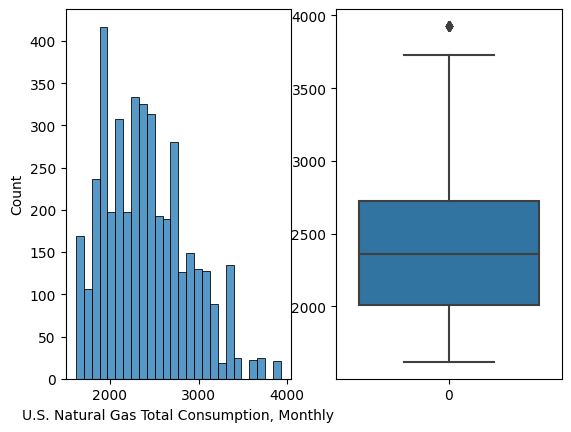

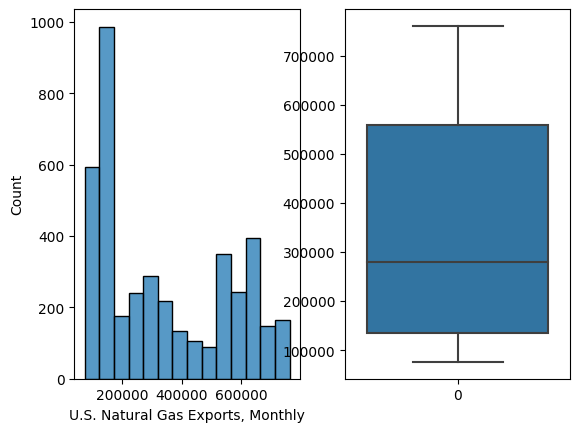

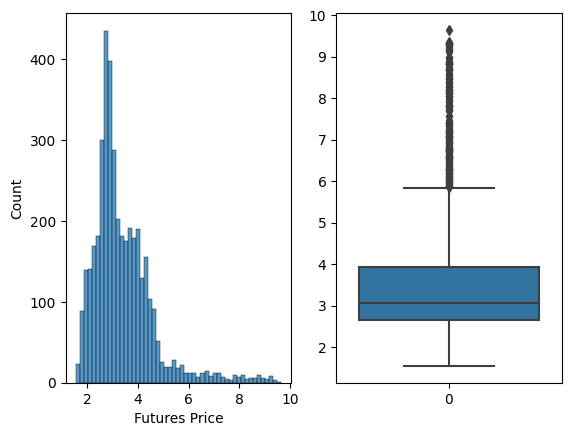

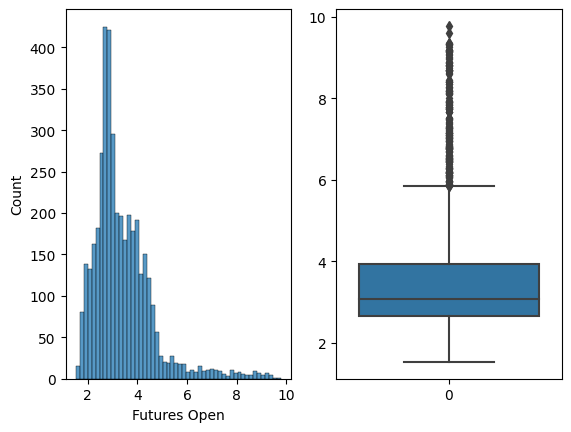

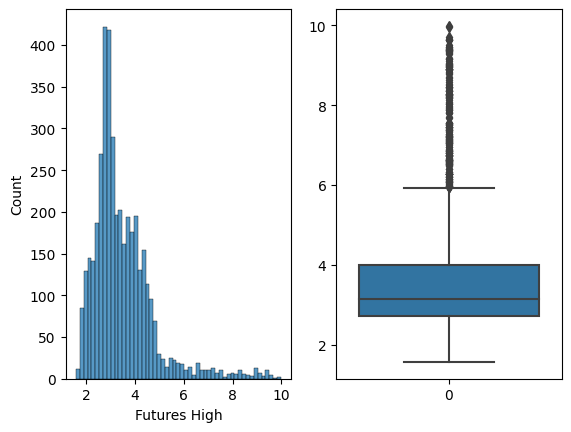

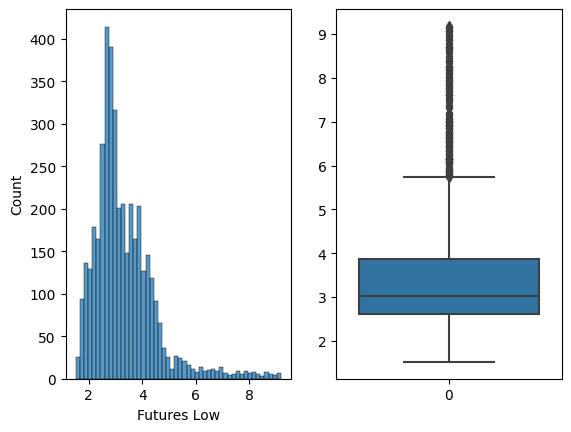

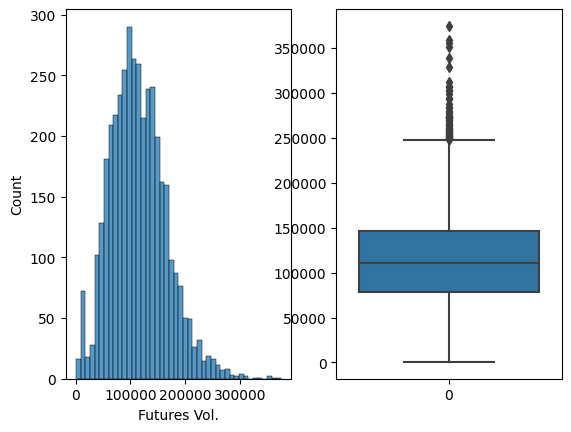

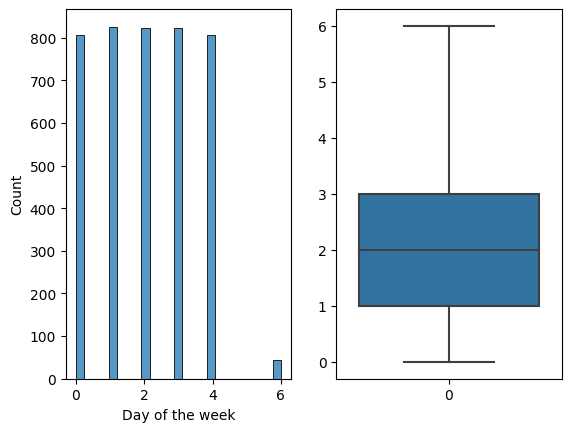

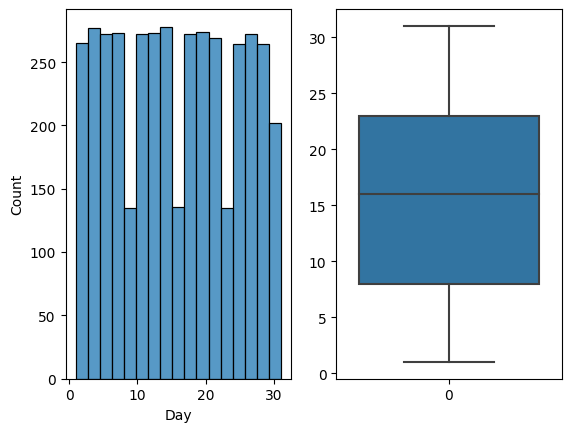

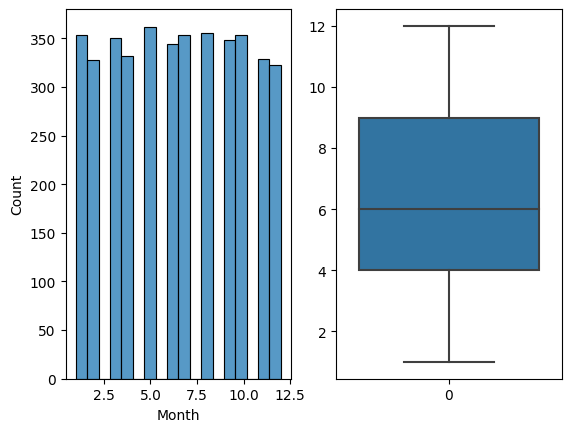

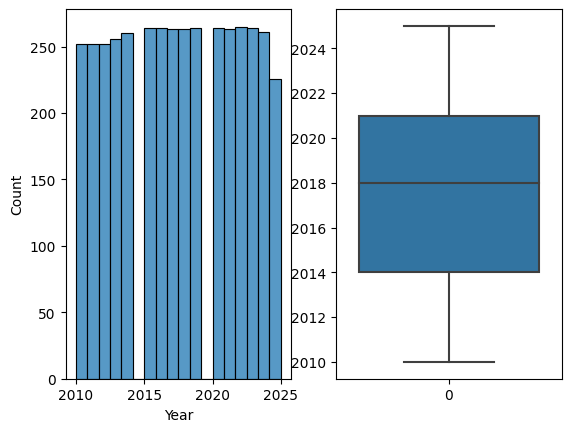

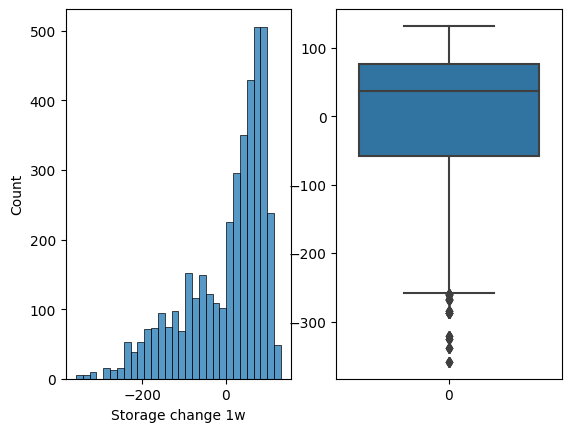

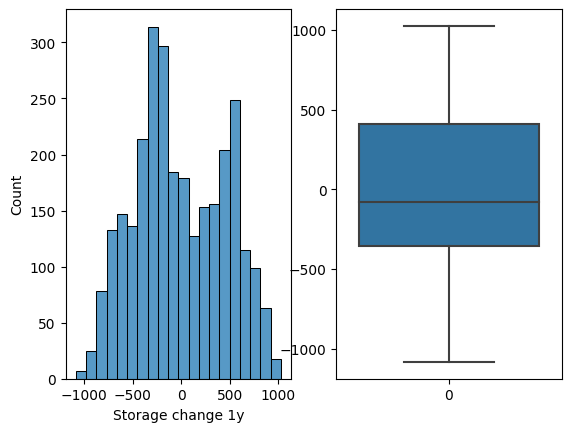

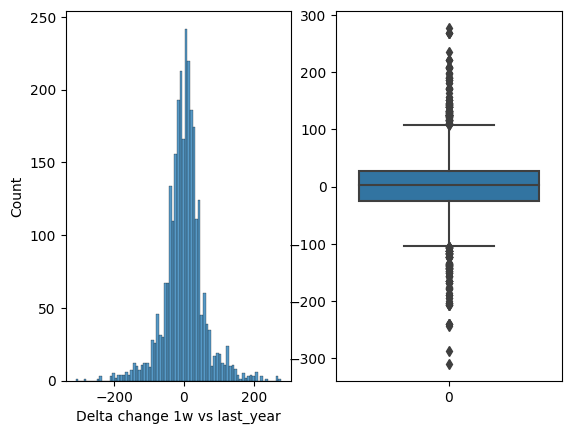

In [19]:
import seaborn as sns

for column in chosen_data_df.columns:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    sns.histplot(chosen_data_df[column], ax=ax1)
    sns.boxplot(chosen_data_df[column], ax=ax2)
    plt.show()

As you can see most of the data has more or less gaussian distribution.

Prices for different contracts as well as exports and number of wells drilled has significant number of outliers.

Scalling of data. As Prices and Exports series has a lot of outliers they need to be treated with robust scalling. Rest of data is scaled with standard scaler.

In [20]:
chosen_data_df.columns

Index(['Henry Hub Natural Gas Spot Price, Daily',
       'Weekly Lower 48 States Natural Gas Working Underground Storage, Weekly',
       'U.S. Dry Natural Gas Production, Monthly',
       'U.S. Natural Gas Total Consumption, Monthly',
       'U.S. Natural Gas Exports, Monthly', 'Futures Price', 'Futures Open',
       'Futures High', 'Futures Low', 'Futures Vol.', 'Day of the week', 'Day',
       'Month', 'Year', 'Storage change 1w', 'Storage change 1y',
       'Delta change 1w vs last_year'],
      dtype='object')

In [39]:
from sklearn import preprocessing

columns_for_robust_scalling = ['U.S. Dry Natural Gas Production, Monthly',
                               'U.S. Natural Gas Exports, Monthly',
                               'Futures Low',
                               'Futures High',
                               'Futures Open',
                               'Futures Price', ]
other_columns = [
    column for column in chosen_data_df.columns if column not in columns_for_robust_scalling]
standard_scaler = preprocessing.StandardScaler()
robust_scaler = preprocessing.RobustScaler()
robust_scaled_data = pd.DataFrame(robust_scaler.fit_transform(
    chosen_data_df[columns_for_robust_scalling]), columns=columns_for_robust_scalling, index=chosen_data_df.index)
min_max_scaled_data = pd.DataFrame(standard_scaler.fit_transform(
    chosen_data_df[other_columns]), columns=other_columns, index=chosen_data_df.index)
chosen_data_df_scaled = pd.merge(robust_scaled_data, min_max_scaled_data, left_index=True, right_index=True)

In [40]:
# Adding target column to df - NG price in next session
chosen_data_df_scaled['Future price in one day'] = chosen_data_df['Futures Price'].shift(
    -1)
# chosen_data_df_scaled['Future 1 in one day'] = chosen_data_df['Natural Gas Futures Contract 1, Daily'].shift(
#     -1)

In [42]:
# Removing rows with NaN values (from shifting)
chosen_data_df_scaled = chosen_data_df_scaled[~chosen_data_df_scaled.isna().any(axis=1)]

In [43]:
# chosen_data_df_scaled = chosen_data_df_scaled.fillna(0)

Creating plot of NG price depending on different series to see if there's any correlation

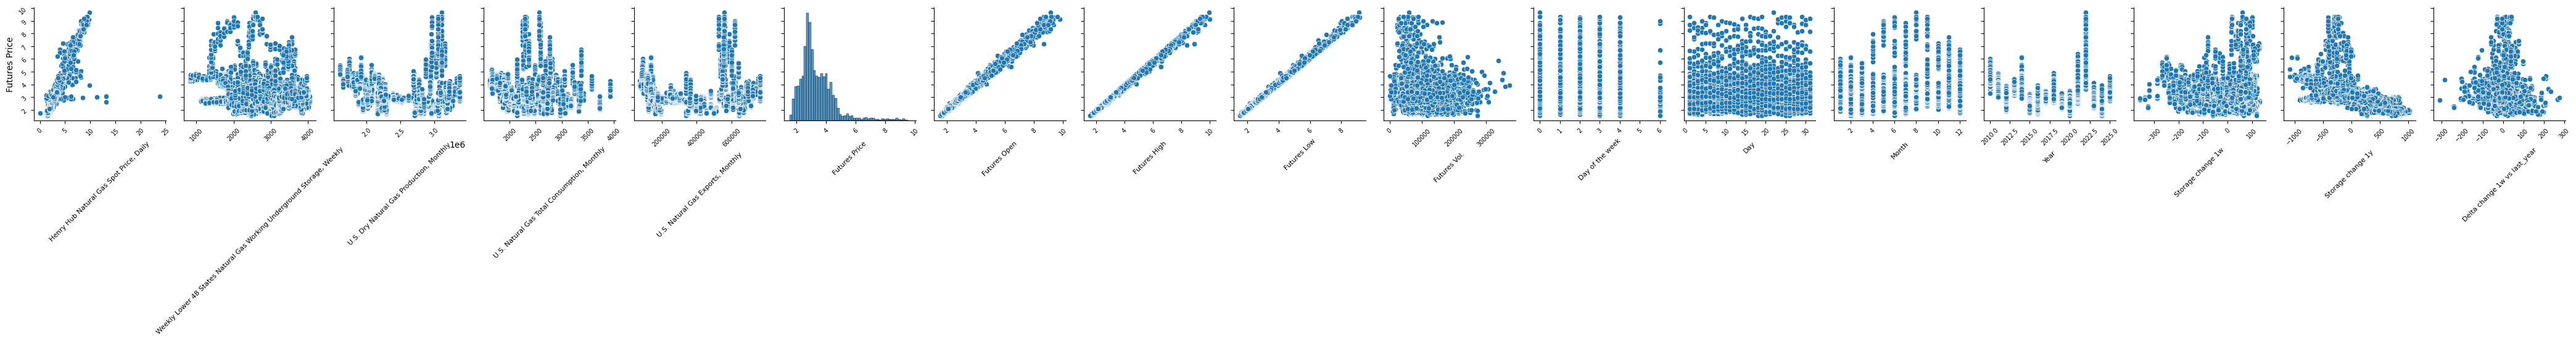

<Figure size 4250x250 with 0 Axes>

In [44]:
from IPython.display import Image

pp = sns.pairplot(data=chosen_data_df,
                  y_vars=['Futures Price'],
                  x_vars=chosen_data_df.columns)
for ax in pp.axes.flat:
    ax.tick_params(labelrotation=45, labelsize=7)
    ax.set_xlabel(xlabel=ax.get_xlabel(), rotation=45, fontsize=8)
pp.savefig('Price correlations.png')

plt.clf()
Image(filename='Price correlations.png')

As you can see there's pretty much no visible relationships between series and price of given contract apart apart from other contracts.

In [45]:
# If you want bigger pair plot and more insight you can uncomment this one
# from IPython.display import Image
# import seaborn as sns
# import matplotlib.pyplot as plt 

# sns_plot = sns.pairplot(chosen_data_df_scaled, height=2.0)
# sns_plot.savefig("pairplot.png")

# plt.clf() # Clean parirplot figure from sns 
# Image(filename='pairplot.png') # Show pairplot as image

In [46]:
# Putting data into time series with batch containing 50 sessions

x_batches = np.array([chosen_data_df_scaled.iloc[i*50:].head(50).drop(columns=[
                     'Future price in one day']).values for i in range(floor(len(chosen_data_df_scaled)/50))])
y_batches = np.array([chosen_data_df_scaled['Future price in one day'].iloc[i*50:].head(
    50).values for i in range(floor(len(chosen_data_df_scaled)/50))])
y_batches = np.expand_dims(y_batches, -1)

In [47]:
for i,col_name in enumerate(chosen_data_df_scaled.columns):
    print(f"Column {i}: {col_name}")

Column 0: U.S. Dry Natural Gas Production, Monthly
Column 1: U.S. Natural Gas Exports, Monthly
Column 2: Futures Low
Column 3: Futures High
Column 4: Futures Open
Column 5: Futures Price
Column 6: Henry Hub Natural Gas Spot Price, Daily
Column 7: Weekly Lower 48 States Natural Gas Working Underground Storage, Weekly
Column 8: U.S. Natural Gas Total Consumption, Monthly
Column 9: Futures Vol.
Column 10: Day of the week
Column 11: Day
Column 12: Month
Column 13: Year
Column 14: Storage change 1w
Column 15: Storage change 1y
Column 16: Delta change 1w vs last_year
Column 17: Future price in one day


In [48]:
# Splitting data into train, val and test sets in 80-10-10 ratio
x_train, x_val, y_train, y_val = train_test_split(
    x_batches, y_batches, test_size=0.2)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5)

In [49]:
import tensorflow as tf

# Metric to check if prediction was in the right direction (ie price goes up or down)
def sign_metric(y_true, y_pred):
    return tf.reduce_mean(tf.cast((((y_true== y_pred) & (y_true==0)) | (y_true*y_pred>0)), tf.float32), axis=-1)

Creating model with early stopping and checkpointing to predict NG price change. I tried various amount of LSTM cells in process but they gave pretty much the same results.

In [52]:
inputs = tf.keras.Input(shape=(x_train.shape[1], x_train.shape[2]))
x = tf.keras.layers.LSTM(4, return_sequences=True, stateful=False)(inputs)
x = tf.keras.layers.LSTM(2, return_sequences=True, stateful=False)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=3e-3), loss="mae")
history = model.fit(x_train, y_train, batch_size=2, epochs=100, validation_data=(x_val, y_val), callbacks=[tf.keras.callbacks.EarlyStopping(patience=10), tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min')])
model.load_weights('best_model.h5')

Epoch 1/100
22/22 [==============================] - 4s 48ms/step - loss: 3.3142 - val_loss: 3.8038
Epoch 2/100
22/22 [==============================] - 0s 17ms/step - loss: 3.1321 - val_loss: 3.6528
Epoch 3/100
22/22 [==============================] - 0s 17ms/step - loss: 2.9471 - val_loss: 3.4757
Epoch 4/100
22/22 [==============================] - 0s 17ms/step - loss: 2.7370 - val_loss: 3.2675
Epoch 5/100
22/22 [==============================] - 0s 17ms/step - loss: 2.4895 - val_loss: 2.9838
Epoch 6/100
22/22 [==============================] - 0s 17ms/step - loss: 2.1695 - val_loss: 2.6032
Epoch 7/100
22/22 [==============================] - 0s 17ms/step - loss: 1.8128 - val_loss: 2.2295
Epoch 8/100
22/22 [==============================] - 0s 16ms/step - loss: 1.5071 - val_loss: 1.9050
Epoch 9/100
22/22 [==============================] - 0s 17ms/step - loss: 1.2825 - val_loss: 1.6441
Epoch 10/100
22/22 [==============================] - 0s 16ms/step - loss: 1.1328 - val_loss: 1.4446

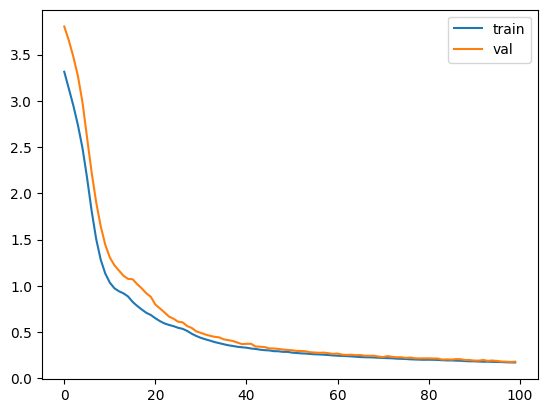

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'])
plt.show()

In [54]:
model.evaluate(x_test, y_test)
y_hat_test = model.predict(x_test)

1/1 [==============================] - 1s 597ms/step


In [55]:
y_hat_test

array([[[2.5413642],
        [2.665979 ],
        [2.7604532],
        [2.7953684],
        [2.8284326],
        [2.8040047],
        [2.897273 ],
        [2.9683285],
        [3.0291615],
        [2.9402628],
        [2.959216 ],
        [2.934074 ],
        [2.941072 ],
        [3.062559 ],
        [3.016409 ],
        [3.031119 ],
        [3.069441 ],
        [3.0618057],
        [3.1160603],
        [3.224389 ],
        [3.233129 ],
        [3.201148 ],
        [3.3145752],
        [3.2954783],
        [3.2796206],
        [3.1449323],
        [3.190034 ],
        [3.2226973],
        [3.1208532],
        [3.1908994],
        [3.154871 ],
        [3.0373557],
        [3.079368 ],
        [3.213679 ],
        [3.2425337],
        [3.1556902],
        [3.184793 ],
        [3.1786556],
        [3.2517037],
        [3.1841252],
        [3.3264372],
        [3.362297 ],
        [3.4105449],
        [3.207141 ],
        [3.1889806],
        [3.162228 ],
        [3.217237 ],
        [3.36

As evaluation on test set shows - this model has MAE's value of 0.41 which is very big and on top of that it correctly predicts direction of change of price only in 47% of cases. It is much too inaccurate to use it in some sort of trading help.

I will try to get more insight to results in following cells

In [56]:
print("x_test shape:", x_test.shape)
print("features in order:", chosen_data_df_scaled.columns.tolist())

x_test shape: (6, 50, 17)
features in order: ['U.S. Dry Natural Gas Production, Monthly', 'U.S. Natural Gas Exports, Monthly', 'Futures Low', 'Futures High', 'Futures Open', 'Futures Price', 'Henry Hub Natural Gas Spot Price, Daily', 'Weekly Lower 48 States Natural Gas Working Underground Storage, Weekly', 'U.S. Natural Gas Total Consumption, Monthly', 'Futures Vol.', 'Day of the week', 'Day', 'Month', 'Year', 'Storage change 1w', 'Storage change 1y', 'Delta change 1w vs last_year', 'Future price in one day']


In [57]:
actual_next_day_prices = np.array(y_test).ravel()
unrolled_y_hat_test = np.array(y_hat_test).ravel()
actual_price = np.roll(actual_next_day_prices, 1)
actual_change = actual_next_day_prices - actual_price
predicted_change = unrolled_y_hat_test - actual_price
comparision_columns = list(zip(actual_next_day_prices, unrolled_y_hat_test, actual_price, actual_next_day_prices-unrolled_y_hat_test, (actual_next_day_prices-unrolled_y_hat_test)/actual_next_day_prices, actual_change, predicted_change, ((actual_change == predicted_change) | (actual_change*predicted_change>0))))
comparision_dataframe = pd.DataFrame(data=comparision_columns, columns=['actual next day price ','prediction', 'current price', 'difference between true price and prediction','relative difference', 'actual change', 'predicted change', 'is same direction?'])
comparision_dataframe.to_csv("comparison_results.csv", index=False)
display(comparision_dataframe.head(20))

,actual next day price,prediction,current price,difference between true price and prediction,relative difference,actual change,predicted change,is same direction?
0,2.627,2.541364,2.617,0.085636,0.032598,0.010,-0.075636,False
1,2.799,2.665979,2.627,0.133021,0.047525,0.172,0.038979,True
2,2.804,2.760453,2.799,0.043547,0.015530,0.005,-0.038547,False
3,2.827,2.795368,2.804,0.031632,0.011189,0.023,-0.008632,False
4,2.901,2.828433,2.827,0.072567,0.025015,0.074,0.001433,True
5,2.901,2.804005,2.901,0.096995,0.033435,0.000,-0.096995,False
6,2.974,2.897273,2.901,0.076727,0.025799,0.073,-0.003727,False
7,3.008,2.968328,2.974,0.039672,0.013189,0.034,-0.005672,False
8,3.043,3.029161,3.008,0.013839,0.004548,0.035,0.021161,True
9,2.981,2.940263,3.043,0.040737,0.013666,-0.062,-0.102737,True


In [58]:
print(len(comparision_dataframe.loc[(comparision_dataframe['relative difference'].abs() > 0.05) & (~comparision_dataframe['is same direction?'])]))
print(len(comparision_dataframe.loc[(comparision_dataframe['relative difference'].abs() > 0.05) & (comparision_dataframe['is same direction?'])]))

14
7


In [59]:
comparision_dataframe['is same direction?'].value_counts()

is same direction?
True     181
False    119
Name: count, dtype: int64

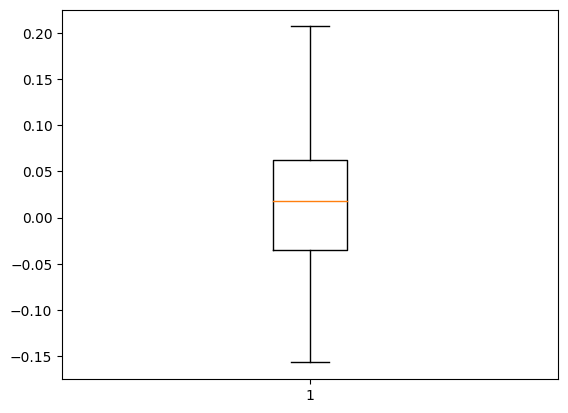

In [60]:
plt.boxplot(comparision_dataframe['difference between true price and prediction'], showfliers=False)
plt.show()

Relative mistakes higher than 5% occurs very often and more frequently with incorrect direction. Median of difference between true change and prediction is not even around 0

### As you can see - unfortunately this approach doesn't work. Chosen series of data provided by EIA isn't enough to predict change of NG price. 

Next I will try to approach this as classification problem (price go up/down/stay the same) and use all of the series provided in file.

## Classification approach

In [61]:
y_classes = np.concatenate((y_batches < 0, y_batches==0, y_batches>0),axis=-1).astype(np.int8)

# Splitting data into train, val and test sets in 80-10-10 ratio
x_class_train, x_class_val, y_class_train, y_class_val = train_test_split(
    x_batches, y_classes, test_size=0.2)
x_class_val, x_class_test, y_class_val, y_class_test = train_test_split(x_class_val, y_class_val, test_size=0.5)

In [62]:
inputs = tf.keras.Input(shape=(x_class_train.shape[1], x_class_train.shape[2]))
x = tf.keras.layers.LSTM(4, return_sequences=True, stateful=False)(inputs)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=1e-3), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy()])
history = model.fit(x_class_train, y_class_train, batch_size=8, epochs=500, validation_data=(x_class_val, y_class_val), callbacks=[tf.keras.callbacks.EarlyStopping(patience=10), tf.keras.callbacks.ModelCheckpoint(filepath='best_class_model.h5', monitor='categorical_accuracy', save_best_only=True, save_weights_only=True, mode='max')])
model.load_weights('best_class_model.h5')

Epoch 1/500
6/6 [==============================] - 2s 104ms/step - loss: 1.1680 - categorical_accuracy: 0.2195 - val_loss: 1.1127 - val_categorical_accuracy: 0.2200
Epoch 2/500
6/6 [==============================] - 0s 20ms/step - loss: 1.1370 - categorical_accuracy: 0.2595 - val_loss: 1.0898 - val_categorical_accuracy: 0.2760
Epoch 3/500
6/6 [==============================] - 0s 21ms/step - loss: 1.1090 - categorical_accuracy: 0.3095 - val_loss: 1.0675 - val_categorical_accuracy: 0.3240
Epoch 4/500
6/6 [==============================] - 0s 20ms/step - loss: 1.0818 - categorical_accuracy: 0.3523 - val_loss: 1.0459 - val_categorical_accuracy: 0.3720
Epoch 5/500
6/6 [==============================] - 0s 18ms/step - loss: 1.0564 - categorical_accuracy: 0.4055 - val_loss: 1.0254 - val_categorical_accuracy: 0.4360
Epoch 6/500
6/6 [==============================] - 0s 19ms/step - loss: 1.0311 - categorical_accuracy: 0.4564 - val_loss: 1.0046 - val_categorical_accuracy: 0.5320
Epoch 7/500
6/6

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'])
plt.show()

In [ ]:
model.evaluate(x_class_test, y_class_test)

### This approach also doesn't work. It reaches accuracy over 50% but it's too small confidence to use this model

Let's try to use one last approach. Classification (as it's easier) with all the data provided by EIA

## Classification with all the data

In [ ]:
from sklearn import preprocessing

columns_for_robust_scalling = ['Henry Hub Natural Gas Spot Price, Daily',
                               'Natural Gas Futures Contract 4, Daily',
                               'Natural Gas Futures Contract 3, Daily',
                               'Natural Gas Futures Contract 2, Daily',
                               'Natural Gas Futures Contract 1, Daily',
                               'U.S. Natural Gas Exports, Monthly',
                               'U.S. Natural Gas Exploratory and Developmental Wells Drilled, Monthly']
other_columns = [
    column for column in all_data_df.columns if column not in columns_for_robust_scalling]
min_max_scaler = preprocessing.StandardScaler()
robust_scaler = preprocessing.RobustScaler(quantile_range=(0.0, 75.0))
robust_scaled_data = pd.DataFrame(robust_scaler.fit_transform(
    all_data_df[columns_for_robust_scalling]), columns=columns_for_robust_scalling, index=all_data_df.index)
min_max_scaled_data = pd.DataFrame(min_max_scaler.fit_transform(
    all_data_df[other_columns]), columns=other_columns, index=all_data_df.index)
all_data_df_scaled = pd.merge(robust_scaled_data, min_max_scaled_data, left_index=True, right_index=True)

In [ ]:
# Adding target column to df - NG price in next session
all_data_df_scaled['Future 1 in one day'] = all_data_df['Natural Gas Futures Contract 1, Daily'].shift(
    -1) - all_data_df['Natural Gas Futures Contract 1, Daily']
# chosen_data_df_scaled['Future 1 in one day'] = chosen_data_df['Natural Gas Futures Contract 1, Daily'].shift(
#     -1)

In [ ]:
all_data_df_scaled = all_data_df_scaled.fillna(0)

In [ ]:
# Putting data into time series with batch containing 50 sessions

all_data_x_batches = np.array([all_data_df_scaled.iloc[i*50:].head(50).drop(columns=[
                     'Future 1 in one day']).values for i in range(floor(len(all_data_df_scaled)/50))])
all_data_y_batches = np.array([all_data_df_scaled['Future 1 in one day'].iloc[i*50:].head(
    50).values for i in range(floor(len(all_data_df_scaled)/50))])
all_data_y_batches = np.expand_dims(all_data_y_batches, -1)

In [ ]:
all_data_y_classes = np.concatenate((all_data_y_batches < 0, all_data_y_batches==0, all_data_y_batches>0),axis=-1).astype(np.int8)

# Splitting data into train, val and test sets in 80-10-10 ratio
all_data_x_class_train, all_data_x_class_val, all_data_y_class_train, all_data_y_class_val = train_test_split(
    all_data_x_batches, all_data_y_classes, test_size=0.2)
all_data_x_class_val, all_data_x_class_test, all_data_y_class_val, all_data_y_class_test = train_test_split(all_data_x_class_val, all_data_y_class_val, test_size=0.5)

In [ ]:
all_data_x_batches.shape

All data contains over 15000 attributes. Network has to be pretty large.

In [ ]:
inputs = tf.keras.Input(shape=(all_data_x_class_train.shape[1], all_data_x_class_train.shape[2]))
x = tf.keras.layers.LSTM(128, return_sequences=True, stateful=False)(inputs)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=1e-3), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy()])
history = model.fit(all_data_x_class_train, all_data_y_class_train, batch_size=8, epochs=500, validation_data=(all_data_x_class_val, all_data_y_class_val), callbacks=[tf.keras.callbacks.EarlyStopping(patience=10), tf.keras.callbacks.ModelCheckpoint(filepath='all_data_best_class_model.h5', monitor='categorical_accuracy', save_best_only=True, save_weights_only=True, mode='max')])
model.load_weights('all_data_best_class_model.h5')

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'])
plt.show()

In [ ]:
model.evaluate(all_data_x_class_test, all_data_y_class_test)

## As expected, using all of the possible data had negative effect on accuracy of prediction of price change. It is the worst model of all created in this notebook.

My understanding is that network had hard time recognizing which attributes were significant and choosing them. Smaller set of attributes gives better probability of getting better model as optimizer has smaller set of paths to go through to optimal solution.

# Summary

## It is not possible to predict Natural Gas price changes for next NYMEX session by using only EIA data.

### It seems like price depends more on speculation, geopolitical news and psychology than hard data about use and distribution of natural gas. Especially given the fact that data used here is registered in hindsight.

# Thank you for your attention